In [1]:
%matplotlib inline
import numpy as np
import backprojection as bp
from scipy.constants import speed_of_light
from scipy.io import loadmat
from matplotlib import pyplot as plt

try:
    import cupy as cp
except ImportError as e:
    raise SystemExit("CuPy가 없습니다. pip install cupy-cudaXX'로 설치하세요.") from e

In [ ]:
import os

def load_sar_mat(fpath:str=None):
    try:
        data = loadmat(fpath)
    except OSError as e:
        raise SystemExit() from e        
    
    data = loadmat(fpath)['data'][0][0].item()
    return data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8]['r_coorect'][0][0], data[8]['ph_coorect'][0][0]

c = 299_792_458.0


def bp_imaging_cupy_streaming(
    mat_paths,                 # azimuth별 .mat 경로 리스트(길이 360)
    x_limits=(-50, 50),
    y_limits=(-50, 50),
    nx=512,
    ny=512,
    z_img=0.0,
    tile_y=64,                 # 픽셀 타일(행) 크기
    time_batch=8,              # time 벡터화 배치 크기 (권장: 4~16)
    freq_chunk=64,             # 주파수 chunk 크기 (권장: 32~128)
    use_float32=True,
    gpu_id=0,
):
    """
    스트리밍: azimuth 파일 1개씩 로드 -> GPU 누적
    벡터화: time 배치(time_batch)로 it 루프 감소
    메모리: freq_chunk로 exp 텐서 폭발 방지
    """

    f_dtype = np.float32 if use_float32 else np.float64
    c_dtype = np.complex64 if use_float32 else np.complex128

    # ---- grid on GPU
    x = np.linspace(x_limits[0], x_limits[1], nx, dtype=f_dtype)
    y = np.linspace(y_limits[0], y_limits[1], ny, dtype=f_dtype)

    with cp.cuda.Device(gpu_id):
        xg = cp.asarray(x)
        yg = cp.asarray(y)
        X, Y = cp.meshgrid(xg, yg)           # (ny, nx)
        img = cp.zeros((ny, nx), dtype=c_dtype)

        z_img_g = f_dtype(z_img)

        # (옵션) CuPy 메모리풀 사용(기본 활성). 필요 시:
        # cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)

        # ---- pixel tiling
        for y0 in range(0, ny, tile_y):
            y1 = min(y0 + tile_y, ny)
            Xt = X[y0:y1, :]                 # (ty, nx)
            Yt = Y[y0:y1, :]

            tile_acc = cp.zeros((y1 - y0, nx), dtype=c_dtype)
            
            min_arrlen = 9999
            # ---- azimuth streaming loop (파일 단위)
            for p in mat_paths:
                fp, freq, ax, ay, az, r0, th, phi, r_cor, ph_cor = load_sar_mat(p)

                # ---- shape normalize (가능한 변형들 흡수)
                # 목표: fp -> (Nf, Nt), freq -> (Nf,), ax/ay/az/r0 -> (Nt,)
                fp = np.asarray(fp)
                freq = np.squeeze(np.asarray(freq))

                if fp.ndim == 3:       # (1, Nf, Nt) or (Nf, Nt, 1) 같은 경우
                    # 흔한 케이스: (1, Nf, Nt)
                    if fp.shape[0] == 1:
                        fp = fp[0]
                    elif fp.shape[-1] == 1:
                        fp = fp[..., 0]
                    else:
                        # (Naz, Nf, Nt)인데 파일에 여러 az가 들어있는 케이스면 첫 az만 사용(필요시 수정)
                        fp = fp[0]

                # fp: (Nf, Nt)
                if fp.shape[0] != freq.size and freq.ndim == 2 and fp.shape[0] == freq.shape[1]:
                    # freq: (1,Nf) or (Nf,1) 등
                    pass

                # freq를 (Nf,)로
                if freq.ndim == 2:
                    freq = freq.reshape(-1)

                # ax..r0 를 (Nt,)로
                ax = np.asarray(ax).reshape(-1)
                ay = np.asarray(ay).reshape(-1)
                az = np.asarray(az).reshape(-1)
                r0 = np.asarray(r0).reshape(-1)

                Nf, Nt = fp.shape

                # ---- move small arrays to GPU (azimuth 1개 분량)
                fp_g = cp.asarray(fp.astype(c_dtype, copy=False))     # (Nf, Nt)
                k_g = (4.0 * cp.pi / f_dtype(c)) * cp.asarray(freq.astype(f_dtype, copy=False))  # (Nf,)

                ax_g = cp.asarray(ax.astype(f_dtype, copy=False))     # (Nt,)
                ay_g = cp.asarray(ay.astype(f_dtype, copy=False))
                az_g = cp.asarray(az.astype(f_dtype, copy=False))
                r0_g = cp.asarray(r0.astype(f_dtype, copy=False))

                # ---- time batching (Nt 루프를 Nt/time_batch로 줄임)
                for t0 in range(0, Nt, time_batch):
                    t1 = min(t0 + time_batch, Nt)
                    B = t1 - t0

                    tx = ax_g[t0:t1]                                  # (B,)
                    ty = ay_g[t0:t1]
                    tz = az_g[t0:t1]
                    rref = r0_g[t0:t1]

                    # dR: (B, ty, nx)
                    dX = Xt[None, :, :] - tx[:, None, None]
                    dY = Yt[None, :, :] - ty[:, None, None]
                    dZ = z_img_g - tz[:, None, None]
                    R = cp.sqrt(dX*dX + dY*dY + dZ*dZ)
                    dR = R - rref[:, None, None]                      # (B, ty, nx)

                    # ---- accumulate over frequency in chunks
                    # out_b: (B, ty, nx)
                    out_b = cp.zeros((B, y1 - y0, nx), dtype=c_dtype)

                    for f0 in range(0, Nf, freq_chunk):
                        f1 = min(f0 + freq_chunk, Nf)
                        kch = k_g[f0:f1]                               # (Fch,)
                        # phase: (B, Fch, ty, nx)
                        phase = cp.exp(1j * kch[None, :, None, None] * dR[:, None, :, :]).astype(c_dtype, copy=False)

                        # fp chunk for B times:
                        # fp_g: (Nf, Nt) → chunk (Fch, B) → (B, Fch)
                        fpch = fp_g[f0:f1, t0:t1].T                    # (B, Fch)

                        # multiply & sum over frequency: (B, ty, nx)
                        out_b += cp.sum(fpch[:, :, None, None] * phase, axis=1)

                    # time 배치(B)까지 합쳐서 타일 누적
                    tile_acc += cp.sum(out_b, axis=0)                  # (ty, nx)

            img[y0:y1, :] = tile_acc

        img_cpu = cp.asnumpy(img)

    return x, y, img_cpu


In [ ]:
fp = []; freq = []; ax = []; ay = []; az = []
r0 = []; th = []; phi = []
r_cor = []; ph_cor = []
    
for iaz in range(1, 361):
    fname = f'data_3dsar_pass8_az{str(iaz).zfill(3)}_VV.mat'
    fpath = os.path.join('/home/rtv-24n10/workspace/7.SAR/SAR_DATA/GOTCHA-CP_Disc2/DATA/pass8/VV', fname)
    
    data = loadmat(fpath)['data'][0][0].item()
            
    fp.append(data[0][:, :119])
    freq.append(data[1])
    ax.append(data[2][:, :119])
    ay.append(data[3][:, :119])
    az.append(data[4][:, :119])
    r0.append(data[5][:, :119])
    th.append(data[6][:, :119])
    phi.append(data[7][:, :119])
    r_cor.append(data[8]['r_correct'][0][0][:, :119])
    ph_cor.append(data[8]['ph_correct'][0][0][:, :119])
    
fp = np.array(fp); print("fp shape: ",fp.shape)
freq = np.squeeze(np.array(freq)); print("freq shape: ",freq.shape)
ax = np.squeeze(np.array(ax)); print("ax shape: ",ax.shape)
ay = np.squeeze(np.array(ay)); print("ay shape: ",ay.shape)
az = np.squeeze(np.array(az)); print("az shape: ",az.shape)
r0 = np.squeeze(np.array(r0)); print("r0 shape: ",r0.shape)
th = np.squeeze(np.array(th)); print("th shape: ",th.shape)
phi = np.squeeze(np.array(phi)); print("phi shape: ",phi.shape)
r_cor = np.squeeze(np.array(r_cor)); print("r_cor shape: ",r_cor.shape)
ph_cor = np.squeeze(np.array(ph_cor)); print("ph_cor shape: ",ph_cor.shape)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Mar 27 14:16:13 2007', '__version__': '1.0', '__globals__': [], 'data': array([[(array([[ 8.9351111e-04+1.10034819e-03j,  8.8404398e-04+2.30856003e-05j,
                 5.1668374e-04-1.16488445e-04j, ...,
                -2.5259965e-04+9.61854821e-05j,  8.2997477e-04-4.80500981e-04j,
                -4.8013256e-04+8.38145439e-04j],
               [ 2.5871845e-05+4.70904459e-04j, -6.8007456e-04-2.74636666e-04j,
                 1.1095409e-03-2.33936022e-04j, ...,
                -1.3125541e-05+7.72384519e-05j,  5.5890629e-04-9.32513620e-04j,
                -3.0366454e-04-3.43800348e-04j],
               [ 9.1831619e-04+1.44519866e-03j,  8.1991515e-04+3.97775002e-04j,
                 1.0273217e-03-3.00714892e-04j, ...,
                 6.2030158e-04-4.49997431e-04j, -1.9679961e-03-8.66823946e-04j,
                 2.6778944e-04-9.46050044e-04j],
               ...,
               [ 2.5079743e-04-2.45997013e-04j,  1

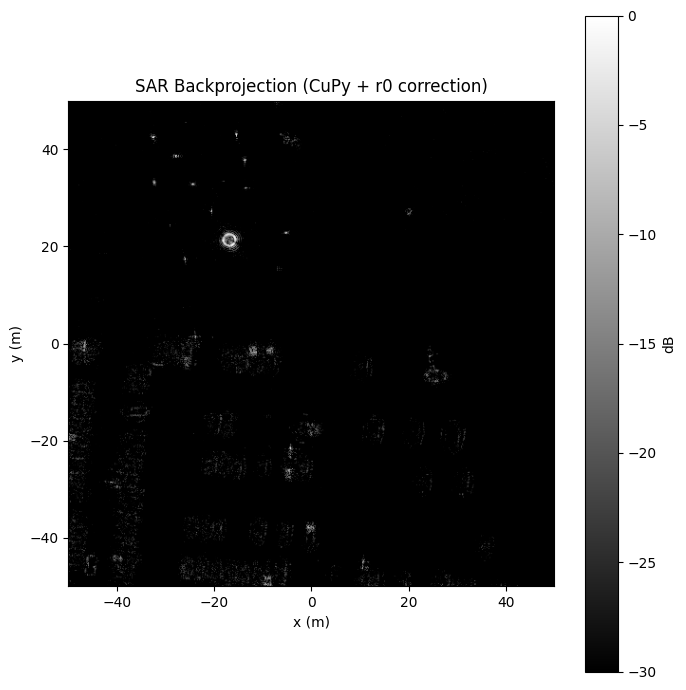

In [ ]:

x, y, img = bp_imaging_cupy_mat(
    fp, freq, ax, ay, az, r0,
    x_limits=(-50, 50),
    y_limits=(-50, 50),
    nx=512,
    ny=512,
    z_img=0.0,
    tile_y=64,          # GPU 메모리 여유 많으면 128~256도 가능
    use_float32=True,   # 속도 최우선
    gpu_id=0,
)


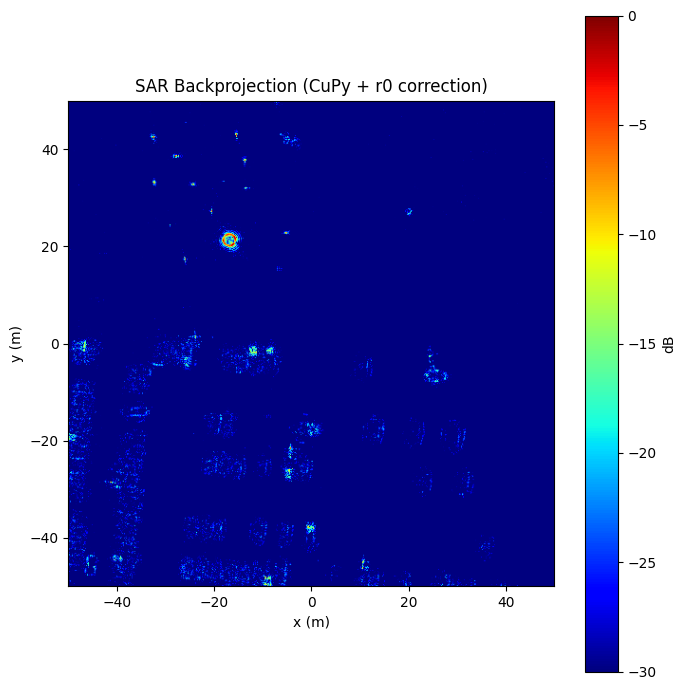

In [5]:

img_mag = np.abs(img)
img_db = 20 * np.log10(img_mag / (img_mag.max() + 1e-12) + 1e-12)

plt.figure(figsize=(7, 7))
plt.imshow(
    img_db,
    extent=[x.min(), x.max(), y.min(), y.max()],
    origin="lower",
    cmap="jet",
    vmin=-30,
    vmax=0
)
plt.colorbar(label="dB")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("SAR Backprojection (CuPy + r0 correction)")
plt.tight_layout()
plt.show()